In [21]:
import numpy as np
import numpy as np
from itertools import permutations
import random
import matplotlib.pyplot as plt


# $\epsilon$-Greedy Algorithm | simoultaneous offers 

In [22]:
T = 100000
epsilon_0 = 0.01
eta = 0.05

## Agents' Initialization
## 5 agents in total, no sex distinction, true values 
N = 6     # Number of Agents 

epsilon_0 = 0.5  # initial probability of exploration
K = np.zeros(N)                                     

# Mean and std deviation of the noise signals (sampled form a std Normal )
noise_mean = 0 
noise_std = 0.5

In [23]:
## Initialization prior beliefs matrix 
## consistent with the priors of thompson sampling,
## we use identical initialization -- (no prior knowledge) and  0 values on the diagonal

np.random.seed(25)
Q = 0.5*np.ones((N, N))
np.fill_diagonal(Q, 0)  

In [24]:
## Initialization prior beliefs of being accepted probailities matrix
np.random.seed(25)
p = np.random.uniform(0, 1, size=(N, N))
np.fill_diagonal(p, 1)  

In [25]:
v = np.random.uniform(0, 0.99, (6,6))
N = 6       # Number of Agents 
np.fill_diagonal(v, 0)

v[0,1] = 1
v[1,0] = 1

v[2, 3] = 1
v[3,2] = 1

v[4,5] = 1
v[5,4] = 1


In [26]:
def greedy_proposal(i, Q , p ):
    '''This function returns the the index of agents to propose 
    under the greedy approach, for agent i '''

    q = np.array(Q[i])
    p_i = np.array(p[i])

    return np.argmax(p_i*q)

In [27]:
def invert_offers(offers):
    ' function to invert the offers being made '
    inverted_offers = {}
    for proposer, recipient in offers.items():
        inverted_offers.setdefault(recipient, []).append(proposer)
    return inverted_offers

In [29]:
def greedy_decision(i, offers, Q):
    'Function that decides wich to accept the offer to greedy decision'

    q = np.array(Q[i, offers])
    return offers[np.argmax(q)]

In [30]:
for t in range(T): 

    ## Each agent does offers 

    offers = {}
    epsilon = epsilon_0**(t/1000)

    for i in range(N):
        if random.random() < epsilon:
        # Exploration: with probability epsilon
            offers[i] = random.choice(list(range(N)))
        else:
        # Greedy: with the remaining probability (1 - epsilon)
            offers[i] = greedy_proposal(i)
        

    #print('Offers \n')

    # print(offers)


    ## Each agent that recieved the offer - decides wheter to accept
    ## they do the greedy decision  
        
    offers_recievers = invert_offers(offers)

    #print('offers recievers \n')

    # print(offers_recievers)

    ## stores the matches 

    m = {}

    for j in offers_recievers.keys():
        m[j] = greedy_decision(j, offers_recievers[j])
        Q[m[j], j] =  Q[m[j], j]/2+  (v[j, m[j]] + np.random.normal(noise_mean, noise_std, 1))/2 ## Update the Q of the observed value - if matches take place
    
   # print('matches \n')
    #print(m)

    ## Update of the probabilities according to the decisions 

    for i in range(N):
        if i in m.items(): 
            k = next((key for key, value in m.items() if value == i), None)
            p[i, k] = (1-eta)*p[i, k] + eta 
        else:
            k = offers[i]  # who they offered 
            p[i, k] = (1-eta)*p[i, k] 

        
       ## No need to update the probability of being chosen in this setting  

        #if i in m.keys(): 
        #   k = m[i]   
        #   c[i, k] = (1-eta)*c[i, k] + eta 
        # else:
        #    c[i, k] = (1-eta)*c[i, k] + eta    

TypeError: greedy_decision() missing 1 required positional argument: 'Q'

In [31]:
def initialize_value_matrix(N):
    # Create an NxN matrix with random values between 5 and 9
    matrix = np.random.uniform(0, 0.99, (N, N))
    
    # Fill the diagonal with 0
    np.fill_diagonal(matrix, 0)
    
    # Set specific symmetric pairs to 1
    for i in range(0, N, 2):
        if i+1 < N:
            matrix[i, i+1] = 1
            matrix[i+1, i] = 1
    
    return matrix

In [32]:
def initialize_prior_Q(N):
    'Initializes the prior values probabilities -- No information uniform initialization'
    # Q = 0.5*np.ones((N, N))
    # np.fill_diagonal(Q, 0)  
    
    Q = np.random.uniform(0, 1, size=(N, N))
    np.fill_diagonal(Q, 0) 

    return Q

In [33]:
def initialize_prior_p(N):
    'Initializes the prior probabilities p  of being accepted -- No information 0.5 initialization'

    # p = np.ones((N, N))
    # np.fill_diagonal(p, 1) 
    p = np.random.uniform(0, 1, size=(N, N))
    np.fill_diagonal(p, 1)  
    return p

In [34]:
def observed_pairs(matrix):
    ' Given the binary allocation matrix returns the true observed pairings '
    n = len(matrix)
    result = []
    for i in range(n):
        for j in range(i+1, n):
            if matrix[i][j] == 1 and matrix[j][i] == 1:
                result.append((i, j))
    return result

In [47]:
def epsilon_greedy(T, N, e = epsilon_0, eta = eta):

    v = initialize_value_matrix(N)      # True values
    Q = initialize_prior_Q(N)           # prior of values
    p = initialize_prior_p(N)           # prior of probabilities 

    ## stable matchings set 

    stable_matching = set((x-1,x) for x in range(1, N, 2))
    n_stable_couples = []
    tau = []


    for t in range(T): 

        ## Proposal phase 
        offers = {}
        epsilon = e**(t/1000)

        for i in range(N):
            if random.random() < epsilon:
            # Exploration: with probability epsilon
                offers[i] = random.choice(list(range(N)))
                
            else:
            # Greedy: with the remaining probability (1 - epsilon)
                offers[i] = greedy_proposal(i, Q, p)
            
        ## Acceptance phase
        offers_recievers = invert_offers(offers)
        m_matrix = np.zeros((N, N)) 

        for j in offers_recievers.keys():
            max_index = greedy_decision(j, offers_recievers[j], Q)
            m_matrix[j, max_index] = 1

        ## Updates 
        for i in range(N):
            for j in range(N):
                if (m_matrix[i, j] == 1) and (m_matrix[j, i] ==1):
                    ## Update the Q of the observed value - if matches take place
                    Q[i, j] =  Q[i, j]/2 +  (v[i, j]/2 + np.random.normal(noise_mean, noise_std, 1))/2 
                    ## update the probability of being accepted 
                    p[i, j] = (1-eta)*p[i, j] + eta 

                else:
                    ## update the probability of not being accepted
                    p[i, j] = (1-eta)*p[i, j] 

        n_stable_couples.append(len( set(observed_pairs(m_matrix)) & stable_matching ))
        tau.append(1 if set(observed_pairs(m_matrix)) == stable_matching else 0 )

    return observed_pairs(m_matrix), n_stable_couples, tau


In [48]:
z, n, t= epsilon_greedy(30000, 6, e = 0.9)

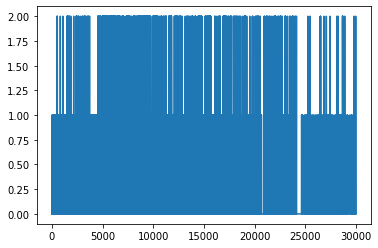

In [46]:
plt.plot(n)

In [121]:
rounds = 100
N_agents = np.arange(6, 20, 2)

In [122]:
result_simulation = {key: 0 for key in N_agents}
T = 10000
for a in N_agents:
    for n in range(rounds): 

        #stable_matching = [(i, i+1) for i in range(0, a, 2)]
        matching, n, t  = epsilon_greedy(T, a)
    
        if  t[-1] == 1: 
            result_simulation[a] += 1 

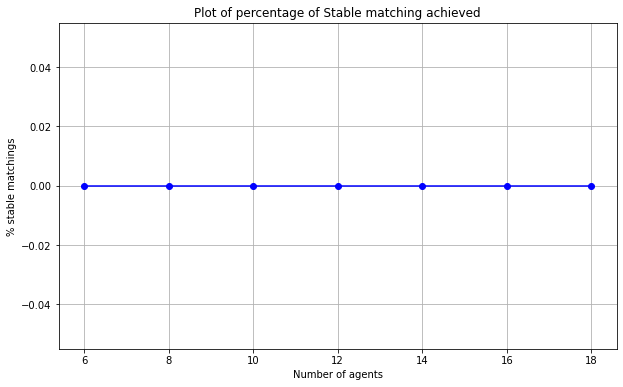

In [123]:
import matplotlib.pyplot as plt

# Provided dictionary

plt.figure(figsize=(10, 6))

plt.plot(result_simulation.keys(), result_simulation.values(), marker='o', linestyle='-', color='blue')
plt.xlabel('Number of agents')
plt.ylabel('% stable matchings')
plt.title('Plot of percentage of Stable matching achieved')
plt.grid(True)
plt.show()

## $\epsilon$- variants simulations -- Das Kamenica paper 

In [124]:
result_simulation_eps = {key: 0 for key in N_agents}
eps_values = np.linspace(0.1, 1, 10)
T = 10000

for e  in eps_values:
    for n in range(rounds): 

        matching, n, t  = epsilon_greedy(T, 8, e)
    
        if  t[-1] == 1: 
            result_simulation_eps[e] += 1 

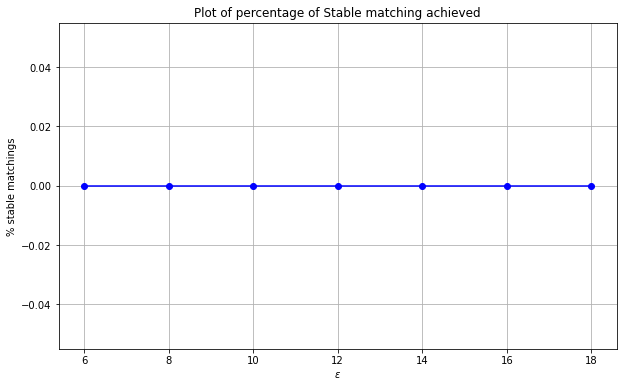

In [125]:
plt.figure(figsize=(10, 6))

plt.plot(result_simulation_eps.keys(), result_simulation_eps.values(), marker='o', linestyle='-', color='blue')
plt.xlabel('$\epsilon$')
plt.ylabel('% stable matchings')
plt.title('Plot of percentage of Stable matching achieved')
plt.grid(True)
plt.show()

## $\epsilon$-Greedy no probabilities

In [143]:
def epsilon_greedy_no_prob(T, N, e = epsilon_0, eta = eta):

    v = initialize_value_matrix(N)      # True values
    Q = initialize_prior_Q(N)           # prior of values
    p = initialize_prior_p(N)           # prior of probabilities 

    ## stable matchings set 

    stable_matching = set((x-1,x) for x in range(1, N, 2))
    n_stable_couples = []
    tau = []


    for t in range(T): 

        ## Proposal phase 
        offers = {}
        epsilon = e**(t/1000)

        for i in range(N):
            if random.random() < epsilon:
            # Exploration: with probability epsilon
                offers[i] = random.choice(list(range(N)))
            else:
            # Greedy: with the remaining probability (1 - epsilon)
                offers[i] = np.argmax(Q[i])
            

        ## Acceptance phase
        offers_recievers = invert_offers(offers)
        m_matrix = np.zeros((N, N)) 

        for j in offers_recievers.keys():
            max_index = greedy_decision(j, offers_recievers[j], Q)
            m_matrix[j, max_index] = 1

        ## Updates 
        for i in range(N):
            for j in range(N):
                if (m_matrix[i, j] == 1) and (m_matrix[j, i] ==1):
                    ## Update the Q of the observed value - if matches take place

                    Q[i, j] =  Q[i, j]/2 +  (v[i, j]/2 + np.random.normal(noise_mean, noise_std, 1))/2 
                    ## update the probability of being accepted 
                    #p[i, j] = (1-eta)*p[i, j] + eta 

                #else:
                    ## update the probability of not being accepted
                    #p[i, k] = (1-eta)*p[i, k] 

        n_stable_couples.append(len( set(observed_pairs(m_matrix)) & stable_matching ))
        tau.append(1 if set(observed_pairs(m_matrix)) == stable_matching else 0 )

    return observed_pairs(m_matrix), n_stable_couples, tau


In [155]:
m, n, t = epsilon_greedy_no_prob(1000, 4)

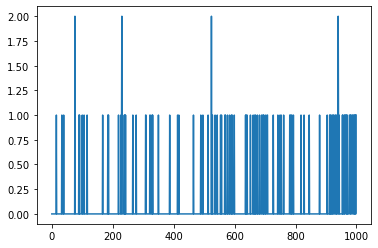

In [156]:
plt.plot(n)

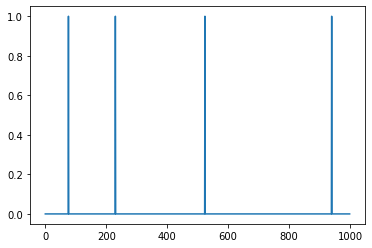

In [157]:
plt.plot(t)